# Shor's Algorithm Based on MindSpore Quantum

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/case_library/mindspore_shor_algorithm.ipynb)&emsp;
[![Download Code](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/case_library/mindspore_shor_algorithm.py)&emsp;
[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_en/case_library/shor_algorithm.ipynb)

## Introduction to Shor's Algorithm

The time complexity of Shor's algorithm to decompose an integer $N$ on a quantum computer is $logN$, which is almost exponential $e$ speedup over the most efficient known classical factorization algorithm, and this speedup may break the modern cryptography such as RSA on a quantum computer.

## Basic Idea of Shor's Algorithm

Shor's algorithm aims to solve the problem: given an integer $N$, find its prime factors. That is, for a given large number $N$, determine two prime factors $p1$ and $p2$ in polynomial time to satisfy $p1\cdot p2=N$. Before introducing the Shor's algorithm, let's learn some basic knowledge of number theory.

We need to learn some basic number theory in order to understand the factorization problem. We can simplified the problem by finding the period of $a$ in the following function:

$$
f(x) = a^x \mod N
$$

where $a$ and $N$ are relatively prime, otherwise a factor can be obtained immediately by calling $gcd(a,N)$. Since the function $f(x)$ has a period of $r$, $f(x)=f(x+r)$ is satisfied. In this case, we can get

$$
a^x = a^{x+r} \mod N \forall x
$$

Set $x=0$, we can get $a^r=1+qN$, where $q$ is an integer,

$$
a^r-1=(a^{r/2}-1)(a^{r/2}+1)=qN
$$

It indicates that the factors of $N$ can be found through finding greatest common divisor.

Therefore, the main idea of Shor's algorithm is to transform the problem of factoring large numbers into the problem of finding the function's period. Since we can use the superposition principle to perform parallel computing in quantum computing, we can quickly find the period $r$ of the function $f(x)$ through quantum algorithms (for specific principles and steps, please refer to the `period finding algorithm` in this document ). In general, we need to implement the function: $f(|x\rangle)=a^{|x\rangle}\ mod\ N$ in the quantum circuit. We can construct a unitary matrix $U_{a,N} $ where $U_{a,N}|x\rangle |y\rangle \rightarrow |x\rangle |y \oplus f(x) \rangle$, and then using Quantum Fourier Transform to find the period $r$ which satisfies $a^r\equiv 1(\ mod\ N)$.

Taking $N=15$ as an example, the steps of Shor's algorithm is introduced as follows,

1. Randomly choose a number, such as $a=2(<15)$

2. Find the greatest common divisor, $\rm gcd(a,N)=gcd(2,15)=1$

3. Find the period of the function $f(x)=a^x\ mod\ N$, so that $f(x+r)=f(x)$

4. Running the quantum circuit we can get $r=4$

5. Find the greatest common divisor, $\gcd(a^{r/2}+1,N)=\gcd(5,15)=5$

6. Find the greatest common divisor, $\gcd(a^{r/2}-1,N)=\gcd(3,15)=3$

7. Hence, the prime factor of 15 are 3 and 5, and the decomposition operation is complete.

The quantum circuit of Shor's algorithm is shown as follows,

![shor's algorithm circuit](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/shor_algorithm_circuit.png)

## Implementing Shor's Algorithm Using MindSpore Quantum

First, we need to import some required modules.

In [1]:
#pylint: disable=W0611
import numpy as np
from fractions import Fraction
import mindquantum as mq
from mindquantum.core.gates import X, Z, H, UnivMathGate, Measure
from mindquantum.core.circuit import Circuit, controlled, UN
from mindquantum.algorithm.library import qft
from mindquantum.simulator import Simulator

From the basic idea of Shor's algorithm, we can see that the main part of Shor's algorithm is period finding subroutine processed by quantum computers, and the most difficult part of the period search algorithm is the operator $U$ which convert the state $|x\rangle |y\rangle$ into $|x\rangle |y \oplus f(x) \rangle$. The quantum circuit structure of this operator is more complicated. Therefore, we will first calculate the operator $U$ through a classical computer and use it as Make an Oracle so that this document can demonstrate Shor's algorithm as a whole and intuitively.

### Constructing the Oracle

The construction of Oracle is merely 3 steps,

1. Exhaustively enumerate all possible $x$ before the transformation ($N$ times from $0$ to $N-1$), and calculate the corresponding $f(x)=a^x\ mod\ N$.
2. For each $x$, we can write the matrix representation of the state before transformation $|x\rangle |0\rangle$ and the state after transformation $|x\rangle |f(x)\rangle$, we can get the transformation matrix corresponding to each $x$ by there tensor product, and then sum all the matrices to get the matrix representation of the operator $U$, that is:

    $$
    U=\sum_{x=0}^{N-1} |x\rangle |0\rangle \langle x|\langle f(x)|
    $$

3. Use the matrix $U$ to generate the custom gate.

Example: $N=15, a=2$, we can obtain $x$ and $f(x)$:

In [2]:
q = 4  # number of qubits
N = 15
a = 2
x = []
f = []
for i in range(2**q):
    x.append(i)
    f.append(a**i % N)
print('x: ', x)
print('f(x): ', f)

x:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
f(x):  [1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8]


We then compute $|0\rangle |0\rangle \langle 0| \langle 1|+|1\rangle |0\rangle \langle 1| \langle 2|+|2\rangle |0\rangle \langle 2|\langle 4|+...$ what we get is the matrix representation of the transformation $U$, where $|0\rangle |0\rangle$, $|0\rangle |1\rangle$, $|0\rangle |2\rangle$... can be expressed as mutually orthogonal column vectors with 256 entries, in which only one entity is 1 and the rest are 0. For example the first element in $|0\rangle |0\rangle$ is 1, the second element in $|0\rangle |1\rangle$ is 1, the 17th element in $|1\rangle |0\rangle$ is 1, and so on.

However, the current version of MindSpore Quantum's Simulator has a limit on the number of bits of the custom gate (which cannot be greater than 5 bits), but when we decomposing the smallest non-even prime factor integer 15=3*5 requires at least 8 bits, so we need to take a much more complicated approach to construct this Oracle using a compromise method, that is, register 1 (4 bits) is used as the control bit, and the corresponding transform $T_x$ is applied to each $x$ in register 2 (4 bits):

$$
T_x|x\rangle \rightarrow |a^x\ mod\ N\rangle
$$

Each $T_x$ is controlled by register 1, and they only works when the number stored in register 1 is $x$. Finally, there are a total of $N$ gates, and the entire circuit including these $N$ gates corresponds to the operator $U$. Note that $T_x$ is not itself a gate, since it is not a reversible operation. Therefore, only when register 2 is in the $|0\rangle$ state, the oracle can give the correct output.

The following is the compromised Oracle construction method:

In [3]:
def U_operator(N, a, register1, register2):
    Q = 2**len(register1)
    x = []
    f = []
    for i in range(Q):
        x.append(i)
        f.append(a**i % N)  # Compute f(x)

    # Create a matrix representation of the quantum state |register2>
    vector = np.zeros((Q, Q))
    for i in range(Q):
        vector[i, i] = 1

    T = []
    for i in range(Q):
        matrix = np.outer(vector[f[i]], vector[0])  # Calculate the matrix that maps Tx
        T.append(UnivMathGate(f'f({i})', matrix))  # Construct Tx "gate" with transformation matrix

# Create a control circuit and get the operator U. For each Tx "gate", it is controlled by all bits in register 1.
# The bit in the binary corresponding to x is a normal control node,
# and if the bit is 0, the X gate is applied on both sides of the control node, flipping control bit.
    circuit = Circuit()
    for i in range(Q):
        bin_x = bin(x[i])[2:]  # Convert x to binary
        flip_control_qubit = list(range(len(register1)))  # Initialize the list of bits that need to act on the X gate

        for j in range(len(bin_x)):
            if bin_x[len(bin_x) - j - 1] == '1':  # Get the '1' bits in the binary of x
                flip_control_qubit.remove(j)  # Remove control bits from the list that do not need to be applied X gate

        circuit.barrier()  # add barrier
        circuit += UN(X, flip_control_qubit)  # Apply the X gate before the control node
        circuit += T[x[i]].on(register2, list(register1))  # Connect the control bits to the Tx "gate"
        circuit += UN(X, flip_control_qubit)  # Apply the X gate after the control node

    return circuit

Now, the `U_operator()` function can perform the modular exponentiation operation on the quantum state $|x\rangle$ in register 1, and store the result $a^{|x\rangle}\ mod\ N$ in the register 2.

For example: in the case of $N=15, a=2$, we construct the corresponding $U$ operator and verify that we can get the correct result (register 1 and register 2 each require 4 bits to store $x$ and $f(x)$):

1¦00010100⟩


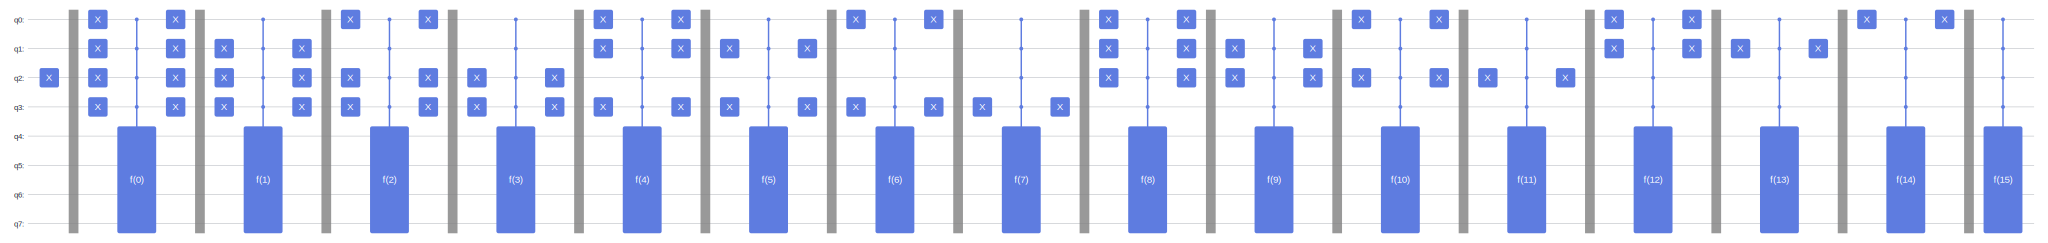

In [4]:
register1 = range(4)
register2 = range(4, 8)
circuit = Circuit(X.on(2))  # Create a circuit where the input state is |0100⟩|0000⟩, that is, x=8, |8⟩|0⟩
circuit += U_operator(15, 2, register1, register2)  # Apply the U operator

print(circuit.get_qs('mqvector', ket=True))  # Print the final state
circuit.svg() # Print circuit

The result in register 1 is 0100 or |0100⟩, and the result in register 2 is 0001 or |0001⟩. We have previously calculated $f(8)=2^8\ mod\ 15=1$, so the output is correct. Although the circuit looks complicated, it is actually just 16 controlled 4-bit gates that act in sequence. The [X](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.XGate.html) gate on the first four bits is used to flip the control bit.

Next we need to implement the period finding algorithm.

### Period Finding Subroutine

1. In register 1, we need $q>log_2 N$ qubits to record the binary number of the variable $x \in [0,N-1]$, and we also need $q$ qubits in register 2 to record $f (x)=a^x\ mod\ N\ \in [0,N-1]$ binary form. At this time, register 1 and register 2 can respectively record the integers of $[0, Q-1]$, where $Q=2^q>N$.
2. The [Hadamard](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.HGate.html) gate is applied to all bits in register 1, and the bits in register 1 are in a uniform superposition state of all integers in $[0,Q-1]$

    $$
    |\psi\rangle=\sum_{x=0}^{Q-1}|x\rangle
    $$

3. Perform function operation $a^{|\psi\rangle}\ mod\ N$ on the state $|\psi\rangle$ stored in register 1, and store the result in register 2. This step is completed by the previously constructed U_operator . Due to the direct operation on the superposition state $|\psi\rangle$, this step can completed in one step, which shows the Quantum Advantage - parallel computing. At this time, the state stored in the circuit is an entangled state, which can be expressed as

    $$
    \sum_{x=0}^{Q-1}|x\rangle|f(x)\rangle=\sum_{i=0}^{r-1}(|i\rangle+|i+r\rangle+| i+2r\rangle+...)\ |f(i)\rangle
    $$

4. Perform an inverse Fourier transform on register 1. This transform uses a $Q$-order unit root $\omega^{2\pi i/Q}$, which evenly distributes the amplitude of any given state $|x\rangle$ on $Q$ states of $|y\rangle$. As shown in step 3, the equivalent states of $|i\rangle$ and $|i+r\rangle$ in register 1 are both entangled with the same state $|f(i)\rangle$ in register 2, with the Quantum interference effect, and finally, when the unit vector $\omega^{2\pi iry/Q}$ is closer to 1 (pointing to the positive real number axis), the probability of measuring the state $|y\rangle$ is greater. In other words, our measured state $|y\rangle$ has a high probability to make $\frac{ry}{Q}$ close to a certain integer $c$. For a more detailed mathematical description, please refer to the link: <https://en.wikipedia.org/wiki/Shor%27s_algorithm>.
5. Measure register 1 to get the binary string. Convert the binary string to the decimal number $y$, at this time $\frac{y}{Q}\sim\frac{c}{r}$, where $c$ is an unknown integer. Calculate the irreducible fraction (the denominator is not greater than $N$) approximated by $\frac{y}{Q}$ using the continued fraction factorization method, the period $r$ is its denominator. However, among irreducible fractions which denominator is less than $N$, there may be fractions that are closer to $\frac{y}{Q}$ than $\frac{c}{r}$, or $c$ and $r$ have a common factor, the obtained $r$ will be the factor of the real function period. At this time, the calculation fails, we need to recalculate.

Taking the example of $N=15, a=2$ again, in `constructing Oracle`, we calculated each $f(x)$, from which we can directly see that the function period is 4. Now we can build the corresponding period-finding subroutine and run 100 simulations to see what we get.

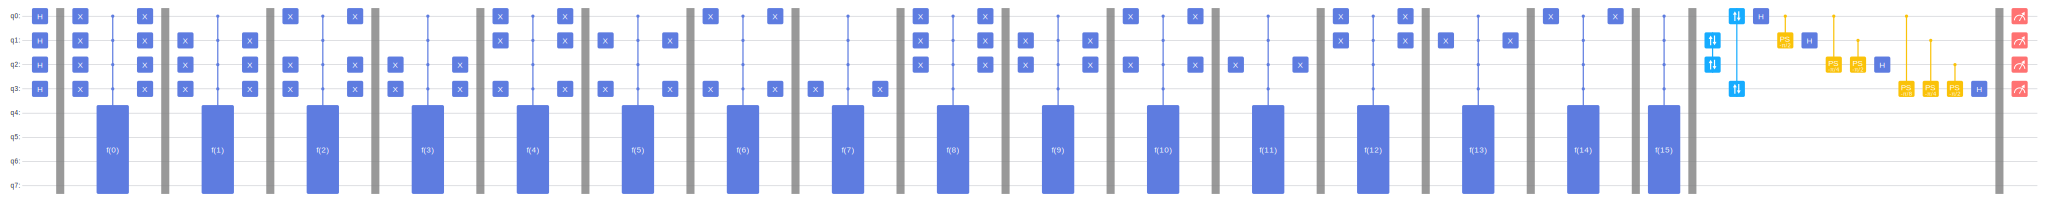

In [5]:
# pylint: disable=W0104
circuit = Circuit() # Create a quantum circuit
register1 = range(4) # Set the first 4 bits to register 1
register2 = range(4, 8) # Set the last 4 bits to register 2

circuit += UN(H, register1) # Apply H gate to all bits in register 1

# Perform a modular multiplication operation on register 1 and store the result in register 2, which is done by a large U gate
circuit += U_operator(15, 2, register1, register2)

circuit.barrier() # Add barrier
circuit += qft(register1[::-1]).hermitian() # Perform the inverse Fourier transform on register 1, pay attention to the bit order of the Fourier transform, reversing the order is required here
circuit.barrier() # Add barrier
circuit += UN(Measure(), register1) # Measure register 1

circuit.svg() # Draw a circuit diagram

As shown in the quantum circuit, it includes four parts in the order-finding subroutine,

1. superposition states generation
2. functional operation
3. inverse Fourier transform
4. measurement

Next, execute the circuit for 100 times and record the results.

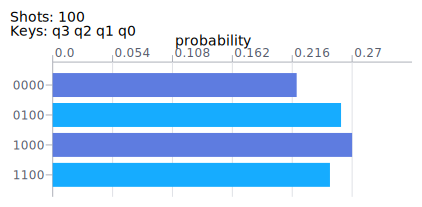

In [6]:
# pylint: disable=W0104
sim = Simulator('mqvector', circuit.n_qubits) # Create a quantum circuit simulator

# Simulate the circuit 100 times, print the measurement results, set the random seed to a random integer within 100
result = sim.sampling(circuit, shots=100, seed=np.random.randint(100))

result.svg()

We can see from the statistical results that only 4 states can be measured in the last register 1, which are $y=[0,4,8,12]$, this is due to $\omega^{2\pi iry/Q} \ (Q=16)$ When $y$ takes these four values, it is exactly 1, and other states cause the probability amplitude canceling to zero due to quantum interference. Substituting the measurement results into $\frac{y}{Q}\sim\frac{c}{r}$, we can see that the formula is indeed true, we have about 50% probability to get the correct period $r$, but there are about 25% probability of getting the factor of $r$, and 25% probability of getting the 0 state, the latter two cases need to be recalculated.

Next we are going to construct a general period-finding algorithm.

In [7]:
def period_finder(N, a, q):
    circuit = Circuit()  # Create a quantum circuit
    register1 = range(q)  # Set the first q bits to register 1
    register2 = range(q, 2 * q)  # Set the last q bits to register 2

    circuit += UN(H, register1)  # Apply H gate to all bits in register 1

    # Perform a modular multiplication operation on register 1 and store the result in register 2, which is done by a large U gate
    circuit += U_operator(N, a, register1, register2)

    circuit += qft(register1[::-1]).hermitian()  # Perform the inverse Fourier transform on register 1, pay attention to the bit order of the Fourier transform, reversing the order is required here
    circuit.barrier()  # Add barrier
    circuit += UN(Measure(), register1)  # Measure register 1

    sim = Simulator('mqvector', circuit.n_qubits)  # Create a quantum circuit simulator

    # Simulate the circuit, collect the measurement results, set the random seed to a random integer within 100
    result = sim.sampling(circuit, seed=np.random.randint(100))

    # result.data is a dictionary, the key is the measurement result, and the value is the frequency of occurrence. We only sampled once, so there is only one key, and the value must be 1
    result = list(result.data.keys())[0]  # Read the key
    result = int(result, 2)  # Convert the result from binary to decimal

    # Using the continued fraction factorization method to calculate the irreducible fraction approximated by result/2**q, the denominator cannot be greater than N
    eigenphase = float(result / 2**q)
    f = Fraction.from_float(eigenphase).limit_denominator(N)
    r = f.denominator  # Take the denominator of f to get the period r

    # r may be a factor of the period, so it needs to be verified, if and only if r is the function period itself, return r, otherwise return None
    if a**r % N == 1:
        return r
    return None

### Classic Computer Part

The classical computer part is responsible for transforming the factorization problem into the problem of finding function period. The specific steps are as follows:

1. Randomly pick an integer $a$ less than $N$, use the gcd algorithm to verify whether $a$ and $N$ are mutually prime, if there is a common factor between $a$ and $N$, then we directly get one of $N$'s factor, output the result.

2. The computation requires $q$ bits to store the binary number of $N$.

3. Use the period finding algorithm to get the period $r$ of the function $f(x)=a^x\ mod\ N$.

4. Determine whether $r$ is an even number, if not, go back to the first step.

5. Calculate $a^{r/2}+1$ and $a^{r/2}-1$, one of them must have a non-1 common factor with $N$. However, $a^{r/2}+1$ may be divisible by $N$, so the final output may still be $N$ itself.

In [8]:
#pylint: disable=C0121,R1705
def shor(N):
    while True:
        a = np.random.randint(N - 2) + 2  # Generate a random integer a in the interval [2,N-1]
        b = np.gcd(a, N)  # Get the greatest common factor b of a and N
        if b != 1:
            return b, int(N / b)  # If b is not equal to 1, then b is a prime factor of N, return the decomposition result

        # Get enough bits q to represent N in binary
        q = 0
        while True:
            Q = 2**q
            if Q >= N:
                break
            q += 1

        r = period_finder(N, a, q)  # Use period finding algorithm to get r

        # Determine whether r is an even number, if so, jump out of the loop, if not, re-select a random integer a
        if r != None and r % 2 == 0:
            break

    # Calculate a**(r/2)+1 and a**(r/2)-1, then verify if they have a common divisor with N, if so, output the result
    c = np.gcd(a**(int(r / 2)) + 1, N)
    d = np.gcd(a**(int(r / 2)) - 1, N)
    if c != 1 and N % c == 0:
        return c, int(N / c)
    else:
        return d, int(N / d)

Since classical computer simulation of quantum algorithms requires a lot of memory, and the previously mentioned simulator in MindSpore Quantum cannot implement multi-qubit gates, such as 5 qubit gates so far. We cannot use Shor's algorithm to calculate the case of $N>21$ for the time being. Finally let's try to decompose $N=15$ using the written Shor's algorithm.

In [9]:
N = 15
print("Factoring N = p * q =", N)

p, q = shor(N)
print("p =", p)
print("q =", q)

Factoring N = p * q = 15
p = 3
q = 5


As we can see from the results, we successfully decomposed 15 into two prime factors 3 and 5.

So far, we have successfully implemented the Shor's algorithm using MindSpore Quantum.

In [10]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.11
scipy,1.10.1
numpy,1.23.5
System,Info
Python,3.9.16
OS,Linux x86_64
Memory,8.3 GB
CPU Max Thread,8
Date,Sat Dec 30 22:54:16 2023
